In [1]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
#import plotly.express as px
import random
from keras.losses import SparseCategoricalCrossentropy

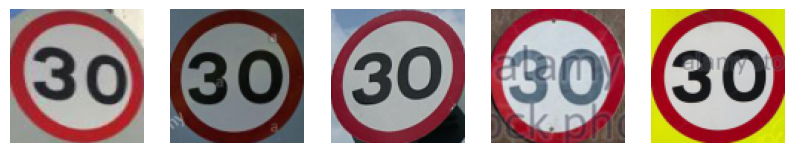

In [3]:
def fetch_image_with_detection_and_visualization(data_folder):
    """
    Fetch images and corresponding labels, perform detection (crop based on bounding boxes),
    and resize to fit the classifier's input. Also visualizes a sample cropped image.
    """
    train_data = []
    test_data = []
    valid_data = []
    cropped_samples = []  # To store a few sample cropped images for visualization
    
    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }
    
    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")
        
        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)
            
            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue
            
            # Load the image without converting to grayscale
            img = Image.open(image_path)
            image_width, image_height = img.size
            img = np.array(img)

            # Parse the label file for bounding boxes
            with open(label_path, "r") as label_file:
                lines = label_file.readlines()
                for line in lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])  # First value is the class ID
                    
                    # Parse normalized bounding box values
                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    # Convert to pixel coordinates
                    x_min = int((x_center - width / 2) * image_width)
                    y_min = int((y_center - height / 2) * image_height)
                    x_max = int((x_center + width / 2) * image_width)
                    y_max = int((y_center + height / 2) * image_height)

                    # Crop the detected region
                    cropped_img = img[y_min:y_max, x_min:x_max]
                    
                    # Resize to match classifier input
                    resized_img = cv2.resize(cropped_img, (90, 90), interpolation=cv2.INTER_AREA)
                    
                    # Normalize the image
                    resized_img = resized_img / 255.0
                    
                    # Store a sample cropped image for visualization (only store the first few samples)
                    if len(cropped_samples) < 5:  # Limit to 5 samples
                        cropped_samples.append(resized_img)
                    
                    # Assign the cropped image and its label to the appropriate split
                    if split_name == "train":
                        train_data.append((resized_img, class_id))
                    elif split_name == "test":
                        test_data.append((resized_img, class_id))
                    elif split_name == "valid":
                        valid_data.append((resized_img, class_id))
    
    # Visualize a few cropped images
    if cropped_samples:
        plt.figure(figsize=(10, 10))
        for i, cropped_img in enumerate(cropped_samples):
            plt.subplot(1, len(cropped_samples), i+1)
            plt.imshow(cropped_img)
            plt.axis('off')
        plt.show()

    return train_data, test_data, valid_data



# Fetch and visualize the cropped images
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image_with_detection_and_visualization(data_folder)

In [4]:
# Prepare training data features and labels
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features).reshape(-1, 90, 90, 3)  # Add channel dimension
training_data_labels = np.array(training_data_labels)

# Prepare validation data
validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features).reshape(-1, 90, 90, 3)
validation_data_labels = np.array(validation_data_labels)

# Prepare test data
test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features).reshape(-1, 90, 90, 3)
test_data_labels = np.array(test_data_labels)

In [5]:
# Check the shape of features and labels
print(f"Training data features shape: {np.array(training_data_features).shape}")
print(f"Training data labels shape: {np.array(training_data_labels).shape}")

Training data features shape: (4298, 90, 90, 3)
Training data labels shape: (4298,)


In [6]:
unique_labels, label_counts = np.unique(training_data_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 542 occurrences
Label 1: 585 occurrences
Label 2: 19 occurrences
Label 3: 267 occurrences
Label 4: 101 occurrences
Label 5: 252 occurrences
Label 6: 285 occurrences
Label 7: 334 occurrences
Label 8: 235 occurrences
Label 9: 283 occurrences
Label 10: 301 occurrences
Label 11: 318 occurrences
Label 12: 323 occurrences
Label 13: 168 occurrences
Label 14: 285 occurrences


In [7]:
cnnModel = Sequential()
cnnModel.add(Conv2D(16,(3,3), padding="same", input_shape=(90, 90, 3), activation='relu'))
print(cnnModel(training_data_features).shape)
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(32,(3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(64,(5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(128,(7,7), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Flatten())
cnnModel.add(Dense(232, activation='relu'))
cnnModel.add(Dense(116, activation='relu'))
cnnModel.add(Dense(15, activation='softmax'))

/home/user/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733856896.215807    1445 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-10 19:54:56.677086: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-12-10 19:54:57.008495: W external/local

(4298, 90, 90, 16)


In [8]:
cnnModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 90, 90, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 232)            │     1,069,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 116)            │        27,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,555,959 (5.94 MB)

 Trainable params: 1,555,959 (5.94 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator
# Define the data augmentation pipeline
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.1,
    rotation_range=45, 
    horizontal_flip=False,
    vertical_flip=False
)

# Fit the generator to your training data
datagen.fit(training_data_features)

In [13]:
cnnModel.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [16]:
SignTraffic = cnnModel.fit(
    datagen.flow(training_data_features, training_data_labels, batch_size=32),
    validation_data=(validation_data_features, validation_data_labels),
    epochs=20
)

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.4300 - loss: 1.6347 - val_accuracy: 0.4778 - val_loss: 1.4704
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.4956 - loss: 1.4666 - val_accuracy: 0.5742 - val_loss: 1.2006
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.5899 - loss: 1.1914 - val_accuracy: 0.7468 - val_loss: 0.7494
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.7316 - loss: 0.7978 - val_accuracy: 0.8093 - val_loss: 0.5716
Epoch 5/20
122/135 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.8010 - loss: 0.6138

KeyboardInterrupt: 

<Axes: >

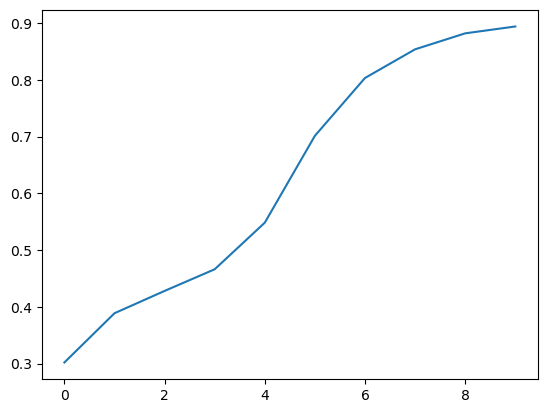

In [25]:
import seaborn as sns
sns.lineplot(SignTraffic.history['accuracy'])

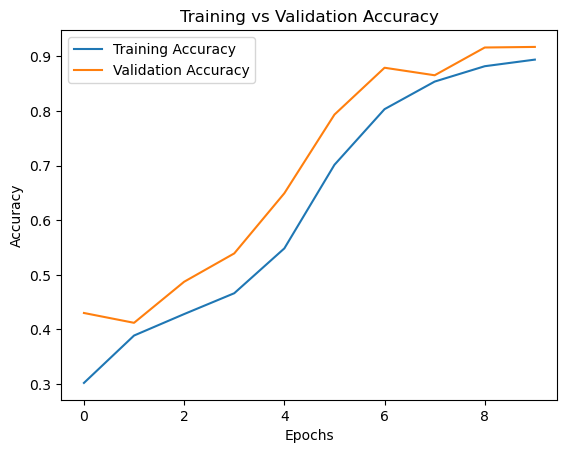

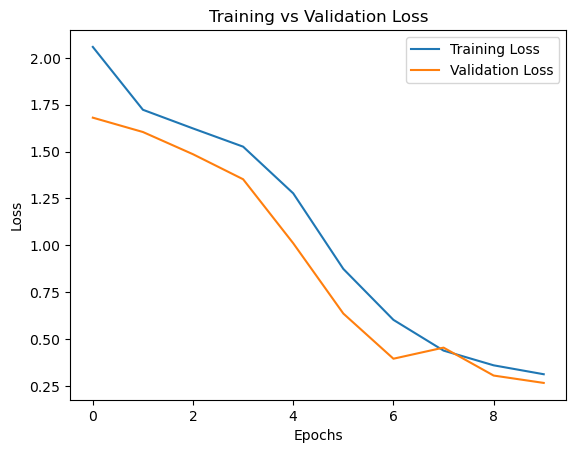

In [29]:
import matplotlib.pyplot as plt
# Assuming history is the result of the model's fit() method
plt.plot(SignTraffic.history['accuracy'], label='Training Accuracy')
plt.plot(SignTraffic.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(SignTraffic.history['loss'], label='Training Loss')
plt.plot(SignTraffic.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


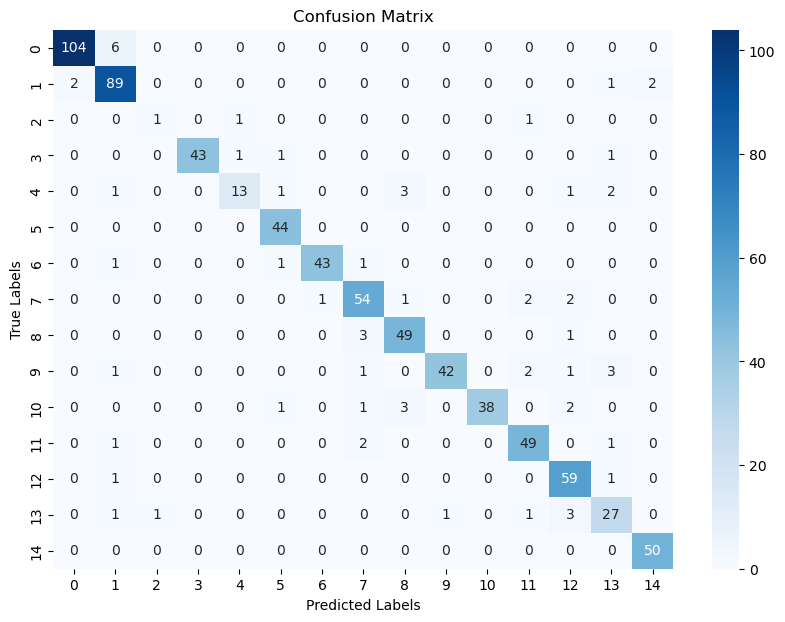

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels on the test data
test_predictions = cnnModel.predict(test_data_features)
# Convert predictions from probabilities to class labels (use argmax to get the index of the highest probability)
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  # sum of the column - TP
    fn = cm[i, :].sum() - tp  # sum of the row - TP
    tn = cm.sum() - (tp + fp + fn)
    
    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


Class 0:
True Positive (TP): 104
False Positive (FP): 2
False Negative (FN): 6
True Negative (TN): 658
Precision: 0.9811
Recall: 0.9455
F1-Score: 0.9630
Accuracy: 0.9896

Class 1:
True Positive (TP): 89
False Positive (FP): 12
False Negative (FN): 5
True Negative (TN): 664
Precision: 0.8812
Recall: 0.9468
F1-Score: 0.9128
Accuracy: 0.9779

Class 2:
True Positive (TP): 1
False Positive (FP): 1
False Negative (FN): 2
True Negative (TN): 766
Precision: 0.5000
Recall: 0.3333
F1-Score: 0.4000
Accuracy: 0.9961

Class 3:
True Positive (TP): 43
False Positive (FP): 0
False Negative (FN): 3
True Negative (TN): 724
Precision: 1.0000
Recall: 0.9348
F1-Score: 0.9663
Accuracy: 0.9961

Class 4:
True Positive (TP): 13
False Positive (FP): 2
False Negative (FN): 8
True Negative (TN): 747
Precision: 0.8667
Recall: 0.6190
F1-Score: 0.7222
Accuracy: 0.9870

Class 5:
True Positive (TP): 44
False Positive (FP): 4
False Negative (FN): 0
True Negative (TN): 722
Precision: 0.9167
Recall: 1.0000
F1-Score: 0.95

In [35]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       110
           1       0.88      0.95      0.91        94
           2       0.50      0.33      0.40         3
           3       1.00      0.93      0.97        46
           4       0.87      0.62      0.72        21
           5       0.92      1.00      0.96        44
           6       0.98      0.93      0.96        46
           7       0.87      0.90      0.89        60
           8       0.88      0.92      0.90        53
           9       0.98      0.84      0.90        50
          10       1.00      0.84      0.92        45
          11       0.89      0.92      0.91        53
          12       0.86      0.97      0.91        61
          13       0.75      0.79      0.77        34
          14       0.96      1.00      0.98        50

    accuracy                           0.92       770
   macro avg       0.89      0.86      0.87       770
weighted avg       0.92   

In [49]:
cnnModel.save("models/model_vf.keras")

In [37]:
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    img = Image.open(image_path)
    print(f"Original Image Size: {img.size}")
    img = img.resize((90, 90))
    img_array = np.array(img)
    # If the image is grayscale (2D array), convert it to 3 channels (RGB)
    if len(img_array.shape) == 2:  # Grayscale image (2D array)
        img_array = np.stack([img_array] * 3, axis=-1)
    
    img_array = img_array / 255.0
    img_array = img_array.reshape(-1, 90, 90, 3)
    print(f"Image Resize: {img_array.shape}")
    return img_array

In [39]:
def predict_image(image_path, model):
    img_array = preprocess_image(image_path)   
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_probability = np.max(predictions, axis=1)[0]
    return predicted_class, predicted_probability

Original Image Size: (416, 416)
Image Resize: (1, 90, 90, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Class: 0
Prediction Probability: 0.7924


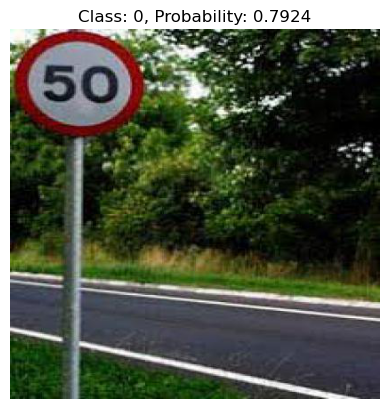

In [51]:
# Example usage
test_path = r"test_img\1.jpg" 
expected_size=(90, 90)
predicted_class, predicted_probability = predict_image(test_path, cnnModel)
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Probability: {predicted_probability:.4f}")
# Display the image
img = Image.open(test_path)
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title(f"Class: {predicted_class}, Probability: {predicted_probability:.4f}")
plt.show()

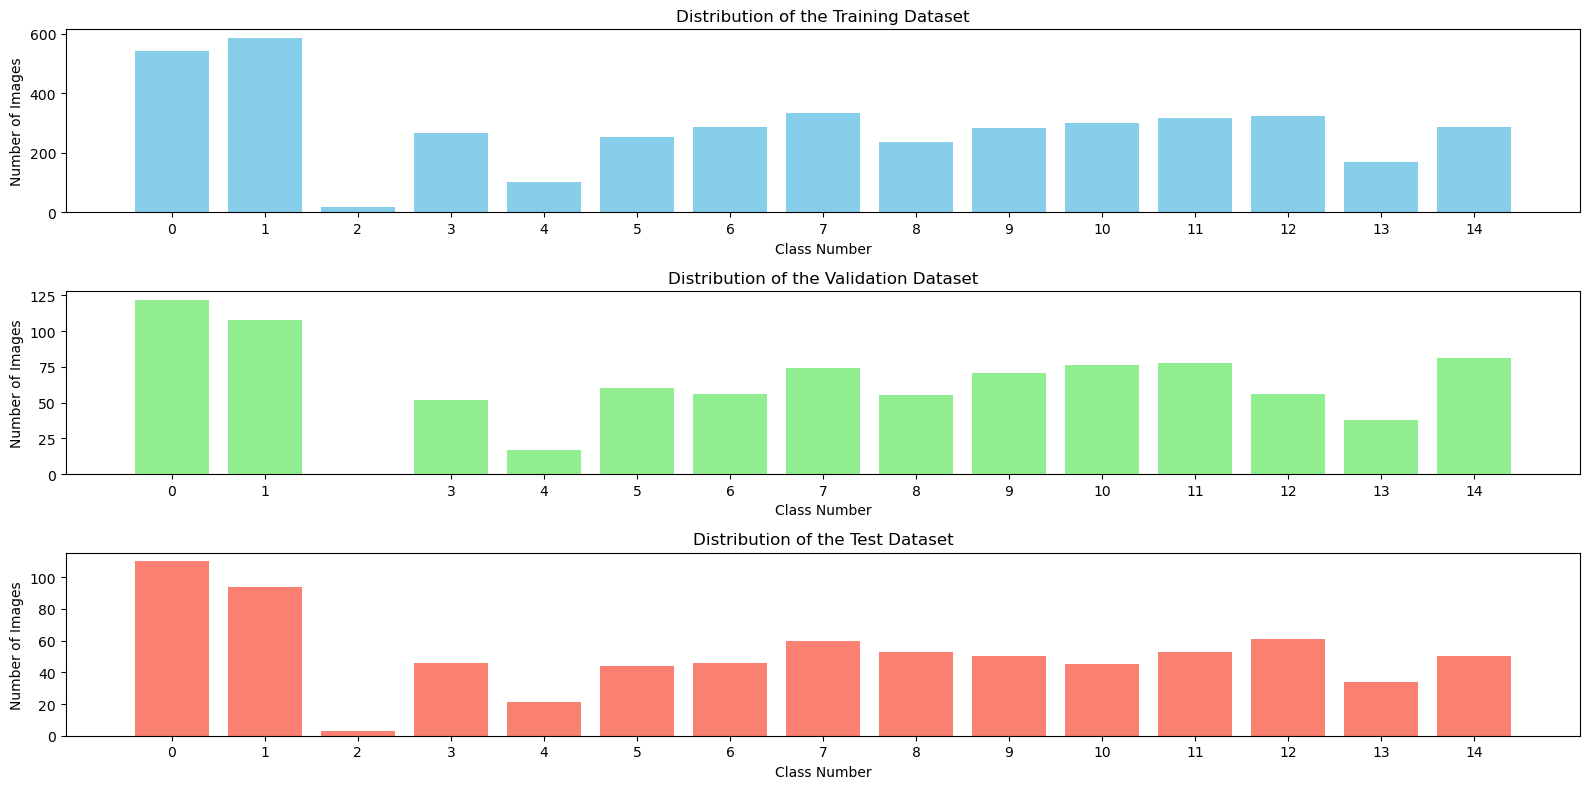

In [45]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming your data is in the form of (image, label) pairs:
# Example: train_data = [(image1, class_id1), (image2, class_id2), ...]
# Replace 'train_data', 'valid_data', 'test_data' with your actual datasets.

# Count the number of samples per class in each dataset
train_class_counts = Counter(class_id for _, class_id in train_data)
valid_class_counts = Counter(class_id for _, class_id in valid_data)
test_class_counts = Counter(class_id for _, class_id in test_data)

# Sort the counts for consistent visualization
train_classes, train_num_of_samples = zip(*sorted(train_class_counts.items()))
valid_classes, valid_num_of_samples = zip(*sorted(valid_class_counts.items()))
test_classes, test_num_of_samples = zip(*sorted(test_class_counts.items()))

# Plot the distributions for all splits
plt.figure(figsize=(16, 8))

# Training Dataset
plt.subplot(3, 1, 1)
plt.bar(train_classes, train_num_of_samples, color='skyblue')
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(train_classes)

# Validation Dataset
plt.subplot(3, 1, 2)
plt.bar(valid_classes, valid_num_of_samples, color='lightgreen')
plt.title("Distribution of the Validation Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(valid_classes)

# Test Dataset
plt.subplot(3, 1, 3)
plt.bar(test_classes, test_num_of_samples, color='salmon')
plt.title("Distribution of the Test Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(test_classes)

# Show the combined plot
plt.tight_layout()
plt.show()